# Family Facial Recognition for Home Security 
By Constantinos Skevofilax and Nikhil Sharma 

The goal of this project is to create a ML model that is able to classify members of a household over 'others', with the goal of integrating this model with a home security camera to determine who is entering a household and notifying the homeowner of who is visiting. 

In [8]:
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [11]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [13]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [14]:
# http://vis-www.cs.umass.edu/lfw/
# LFW Dataset for the 'others' 
!tar -xf lfw.tgz


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [15]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [16]:
num_files = len(os.listdir(NEG_PATH))

In [17]:
num_files

1555

## Data Augmentation 
We want to create a comparable family data set that will match the size of the negatives dataset. We will achieve this by using image augmentation methods such as flipping, stretching, and rotating images. comproable 

In [18]:
# Data Augmentation to match negative amount of 1555 
import urllib.request
import shutil
from IPython.display import Image

In [20]:
pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 22.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.2/779.2 MB 707.8 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 5.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: triton
    Found existing installation: triton 2.2.0
    Uninstalling triton-2.2.0:
      Successfully uninstalled triton-2.2.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.19.3
    Uninstalling nvidia-nccl-cu12-2.19.3:
      Successfully uninstalled nvidia-nccl-cu12-2.19.3
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1
    Uninstalling torch-2.2.1:
      Successfully uninstalled torch-2.2.1

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the k

In [25]:
import os
import torch
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from PIL import Image

In [41]:
from torchvision.transforms.functional import to_pil_image

def save_augmented_images(img_file, transform, save_path):
    # Load the requested image
    img = Image.open(img_file).resize((256, 256))

    # Apply transformations to the image
    augmented_images = [transform(img) for _ in range(4)]
    for i, augmented_img_tensor in enumerate(augmented_images):
        # Convert tensor to PIL Image
        augmented_img_pil = to_pil_image(augmented_img_tensor)
        # Save augmented image
        augmented_img_pil.save(os.path.join(save_path, f"{os.path.splitext(os.path.basename(img_file))[0]}_aug_{i}.jpg"))


In [42]:
def visualize_generator(img_file, transform):
    # Load the requested image
    img = Image.open(img_file).resize((256,256))

    # Apply transformations to the image
    imgs = [transform(img) for _ in range(4)]
    imgs = torch.stack(imgs)

    # Display the augmented images in a grid format
    grid = make_grid(imgs, nrow=2)

    # Convert to numpy for plotting
    grid_np = grid.numpy().transpose(1, 2, 0)
    grid_np = (grid_np * 255).astype(np.uint8)

    plt.figure(figsize=(15, 15))
    plt.axis("off")
    plt.imshow(grid_np)
    plt.show()

In [43]:
# Flips, "moves", adjusts brightness, and rotates family dataset to have a comparable number to the negatives 
# dataset size (1555 images)
transforms_list = [
    transforms.Compose([
        transforms.RandomAffine(degrees=0, translate=(0.5, 0)),
        transforms.Pad(padding=200, fill=0, padding_mode='edge'),
        transforms.ToTensor()
    ]),
    transforms.Compose([
        transforms.ColorJitter(brightness=(0, 1)),
        transforms.ToTensor()
    ]),
    transforms.Compose([
        transforms.RandomAffine(degrees=30),
        transforms.ToTensor()
    ])
]

In [45]:
# Loop through each image file in the directory
for img_file in os.listdir(POS_PATH):
    # Check if the file is an image file
    if img_file.endswith('.jpg'):
        # Get the full path to the image file
        img_path = os.path.join(POS_PATH, img_file)
        # Apply each transformation set and visualize the result
        for transform in transforms_list:
            save_augmented_images(img_path, transform, POS_PATH)

In [66]:
# Loop through each image file in the directory
for img_file in os.listdir(ANC_PATH):
    # Check if the file is an image file
    if img_file.endswith('.jpg'):
        # Get the full path to the image file
        img_path = os.path.join(ANC_PATH, img_file)
        # Apply each transformation set and visualize the result
        for transform in transforms_list:
            save_augmented_images(img_path, transform, ANC_PATH)

In [67]:
num_files2 = len(os.listdir(POS_PATH))
num_files2

num_files3 = len(os.listdir(ANC_PATH))
num_files3

673

## Preprocessing - Scaling and Resizing images 

In [48]:
# Preprocess images 
def preprocess(file_path): 
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img    

In [109]:
# Mapping the anchors and the positives to each others 
anchor_teresa = tf.data.Dataset.list_files(ANC_PATH+'/teresa/*.jpg')
positive_teresa = tf.data.Dataset.list_files(POS_PATH+'/teresa/*.jpg')

anchor_athena = tf.data.Dataset.list_files(ANC_PATH+'/athena/*.jpg')
positive_athena = tf.data.Dataset.list_files(POS_PATH+'/athena/*.jpg')

anchor_costaki = tf.data.Dataset.list_files(ANC_PATH+'/costaki/*.jpg')
positive_costaki = tf.data.Dataset.list_files(POS_PATH+'/costaki/*.jpg')

anchor_george = tf.data.Dataset.list_files(ANC_PATH+'/george/*.jpg')
positive_george = tf.data.Dataset.list_files(POS_PATH+'/george/*.jpg')

negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(600)

## Labeling Dataset 

In [110]:
positives_teresa = tf.data.Dataset.zip((anchor_teresa, positive_teresa, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_teresa)))))
positives_athena = tf.data.Dataset.zip((anchor_athena, positive_athena, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_athena)))))
positives_costaki = tf.data.Dataset.zip((anchor_costaki, positive_costaki, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_costaki)))))
positives_george = tf.data.Dataset.zip((anchor_george, positive_george, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor_george)))))

# Combine positive examples for all individuals
positives = positives_teresa.concatenate(positives_athena).concatenate(positives_costaki).concatenate(positives_george)

# Get negatives 
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))

# Combine positive and negative examples
data = positives.concatenate(negative.map(lambda x: (x, x, tf.constant(0, dtype=tf.float32))))

# Shuffle the dataset
data = data.shuffle(buffer_size=1000)

In [111]:
samples = data.as_numpy_iterator()

In [112]:
example = samples.next()

In [113]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [114]:
res = preprocess_twin(*example)

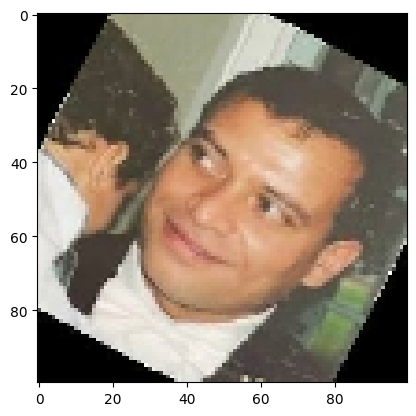

In [115]:
plt.imshow(res[1])

In [116]:
res[2]

1.0